## SARIMAX Model

### 1. Import libraries and get data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [3]:
# Load the dataset
df = pd.read_csv("./USDT-Monthly.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Format the 'Date' column
# df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Close
Date,
2017-12-01,1.012260
2018-01-01,0.990274
2018-02-01,0.998903
2018-03-01,1.000770
2018-04-01,0.998919
...,...
2022-12-01,0.999674
2023-01-01,1.000117
2023-02-01,1.000154


### 2. Split data train/test

In [4]:
# Split the data into training (60%) and test (40%) sets
train_size = int(0.6 * len(df))

train = df[:train_size][['Close']]
test = df[train_size:][['Close']]

# Check the sizes of the data sets
print("Train shape:", train.shape)
print("Test shape:", test)

Train shape: (39, 1)
Test shape:                Close
Date                
2021-03-01  1.000020
2021-04-01  1.000009
2021-05-01  1.000533
2021-06-01  1.000216
2021-07-01  1.000272
2021-08-01  1.000529
2021-09-01  1.000155
2021-10-01  1.000376
2021-11-01  1.000286
2021-12-01  1.000189
2022-01-01  1.000485
2022-02-01  1.000351
2022-03-01  1.000304
2022-04-01  1.000155
2022-05-01  0.999388
2022-06-01  0.998819
2022-07-01  1.000328
2022-08-01  1.000016
2022-09-01  1.000049
2022-10-01  0.999947
2022-11-01  1.000015
2022-12-01  0.999674
2023-01-01  1.000117
2023-02-01  1.000154
2023-03-01  1.000124
2023-04-01  1.000438


## 3. Perform SARIMAX Model

### 3.1 Seasonal train data

In [5]:
result_mul = seasonal_decompose(train.Close[-36:], model='multiplicative', extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

train['month'] = train.index.month
train = pd.merge(train, seasonal_index, how='left', on='month')
train.columns = ['Close', 'month', 'seasonal_index']

### 3.2 Build model

In [6]:
# SARIMAX Model
import pmdarima as pmd

SARIMAX_model = pmd.auto_arima(train[['Close']], exogenous=train[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

SARIMAX_model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-175.267, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-169.430, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-169.556, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-176.423, Time=0.39 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-177.260, Time=0.27 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-176.887, Time=0.55 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-175.288, Time=1.58 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-173.119, Time=0.25 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=-176.494, Time=0.37 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-169.550, Time=0.04 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=-175.734, Time=0.22 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=-178.202, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=-177.828, Time=0.71 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-175.943, Time=0.80 sec
 ARIMA(0,1,1)(1,1,1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   39
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                  92.101
Date:                             Wed, 03 May 2023   AIC                           -178.202
Time:                                     23:06:10   BIC                           -174.427
Sample:                                          0   HQIC                          -177.115
                                              - 39                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0004      0.000     -1.649      0.099      -0.001     7.5e-05
ma.L1         -0.9227      0.356     -2.590      0.010      -1.621      -0.225
sigma2      4.554e-05   2.13e-05      2.133      0.033     3.7e-06    8.74e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.65   Prob(JB):                         0.61
Heteroskedasticity (H):               0.41   Skew:                            -0.17
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### 3.3 Seasonal Test data

In [8]:
result_mul = seasonal_decompose(test.Close[-24:], model='multiplicative', extrapolate_trend='freq')

seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

test['month'] = test.index.month
test_seasonal = pd.merge(test, seasonal_index, how='left', on='month')
test_seasonal.columns = ['Close', 'month', 'seasonal_index']
test_seasonal.index = test.index

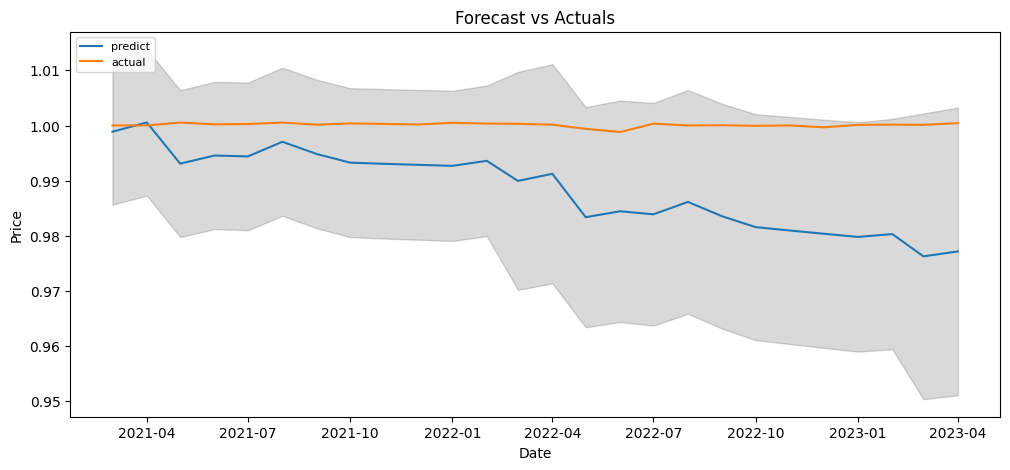

In [18]:
fitted, confint = SARIMAX_model.predict(n_periods=26, 
                                            return_conf_int=True,
                                            exogenous=test_seasonal[['seasonal_index']])


# make series for plotting purpose
fitted_series = pd.Series(fitted.values, index=test.index)
lower_series = pd.Series(confint[:, 0], index=test.index)
upper_series = pd.Series(confint[:, 1], index=test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(fitted_series, label='predict')
plt.plot(test.Close, label='actual')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper left', fontsize=8)
plt.show()
